In [4]:
!ls stocks_latest

dividends_latest.csv    earnings_latest.csv     stock_prices_latest.csv


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('dataset_summary.csv')
df.head()

,symbol,total_prices,stock_from_date,stock_to_date,total_earnings,earnings_from_date,earnings_to_date
0,A,5135,1999-11-18,2020-04-17,44,2009-05-14,2020-02-18
1,AA,870,2016-11-01,2020-04-17,14,2017-01-24,2020-04-22
2,AAAP,574,2015-11-11,2018-07-18,0,NaN,NaN
3,AABA,5486,1998-01-02,2020-03-10,14,2014-01-28,2017-04-18
4,AAC,1292,2014-10-02,2020-04-07,22,2014-11-05,2019-08-30


In [17]:
df = pd.read_csv('stocks_latest/stock_prices_latest.csv', parse_dates=['date'])
df.head()

,symbol,date,open,high,low,close,close_adjusted,volume,split_coefficient
0,MSFT,2016-05-16,50.80,51.96,50.75,51.83,49.7013,20032017,1.0
1,MSFT,2002-01-16,68.85,69.84,67.85,67.87,22.5902,30977700,1.0
2,MSFT,2001-09-18,53.41,55.00,53.17,54.32,18.0802,41591300,1.0
3,MSFT,2007-10-26,36.01,36.03,34.56,35.03,27.2232,288121200,1.0
4,MSFT,2014-06-27,41.61,42.29,41.51,42.25,38.6773,74640000,1.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22228563 entries, 0 to 22228562
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   symbol             object        
 1   date               datetime64[ns]
 2   open               float64       
 3   high               float64       
 4   low                float64       
 5   close              float64       
 6   close_adjusted     float64       
 7   volume             int64         
 8   split_coefficient  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 1.5+ GB


In [21]:
stock = ['A']
A = df[df.symbol.isin(stock)]

In [23]:
A.set_index('date', inplace=True)
A.sort_index(inplace=True)

In [24]:
A.head()

,symbol,open,high,low,close,close_adjusted,volume,split_coefficient
date,,,,,,,,
2016-04-12,A,39.47,39.825,39.34,39.75,39.0836,992495,1.0
2014-11-20,A,40.56,41.427,40.56,41.26,39.9291,2303826,1.0
2017-08-21,A,61.09,62.000,60.96,61.74,61.4778,1429027,1.0
2005-09-02,A,32.29,32.400,32.05,32.14,21.8459,1870300,1.0
2003-11-12,A,25.88,27.000,25.73,26.87,18.2638,2770900,1.0


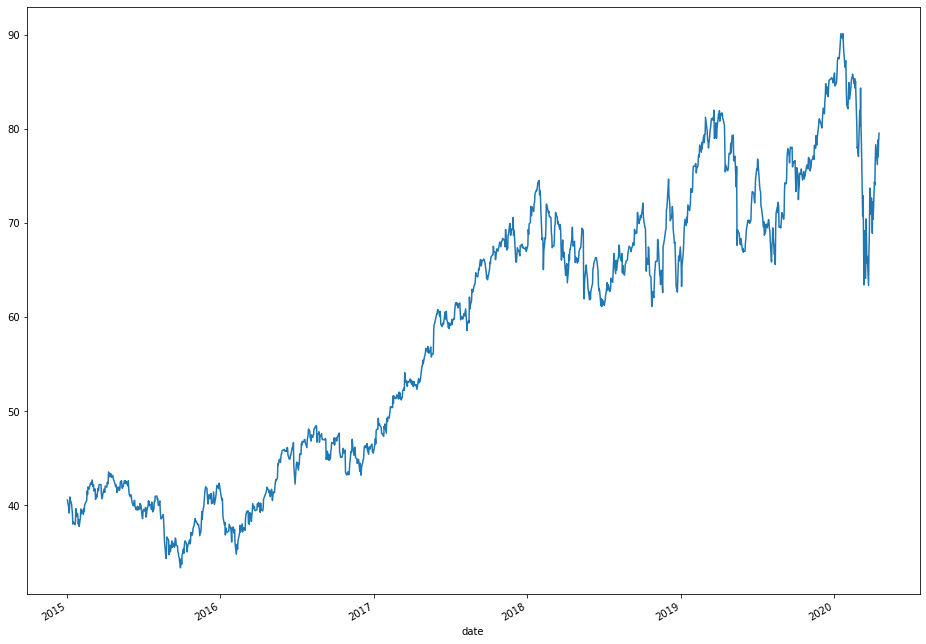

In [29]:
A.truncate(before='2015-01-01')['close'].plot(figsize=(16,12))

In [32]:
by_symbol = df.groupby(['date','symbol'])

In [36]:
by_symbol

AttributeError: 'DataFrameGroupBy' object has no attribute 'unstack'